#Задание для курсового проекта:

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score) Сдача проекта:

1.Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook;

2.Необходимо получить R2 > 0.6. Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):

1.Файл должен содержать заголовки и комментарии;

2.Повторяющиеся операции лучше оформлять в виде функций;

3.По возможности добавлять графики, описывающие данные (около 3-5);

4.Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта;

5.Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний);

6.Весь проект должен быть в одном скрипте (файл ipynb);

7.При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна;

8.Проект должен полностью отрабатывать за разумное время" (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.


Необходимые библиотеки:

In [59]:
import numpy as np
import pandas as pd
import random
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [60]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
matplotlib.rcParams.update({'font.size': 14})

In [62]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values) :
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print ("Test R2:\t" + str(round (r2(test_true_values, test_pred_values), 3)))
    plt. figure(figsize=(18,10))

    plt.subplot (121)
    sns. scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel ('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction' )

    plt.subplot (122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel( 'True values')
    plt.title('Test sample prediction')

    plt.show()

Пути к директориям и файлам:

In [63]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

Загрузка данных:

Описание датасета:

• Id - идентификационный номер квартиры;

• Districtld - идентификационный номер района;

• Rooms - количество комнат;

• Square - площадь;

• LifeSquare - жилая площадь;

• KitchenSquare - площадь кухни;

• Floor - этаж;

• HouseFloor - количество этажей в доме;

• HouseYear - год постройки дома;

• Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности;

• Social_1, Social_2, Social_3 - социальные показатели местности;

• Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья;

• Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров;

• Price - цена квартиры.

In [64]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df. tail()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [65]:
train_df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [66]:
print ('Строк в трейне:', train_df.shape [0])
#print ('Строк 6 трейне:', test_df.shape [0])

Строк в трейне: 10000


In [67]:
train_df.shape[1] #столбцы

20

Приведение типов:

In [68]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [69]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [70]:
train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

EDA:

Делаем EDA для:

• Исправления выбросов;

• Заполнения NaN;

• Идей для генерации новых фич

<function matplotlib.pyplot.show(close=None, block=None)>

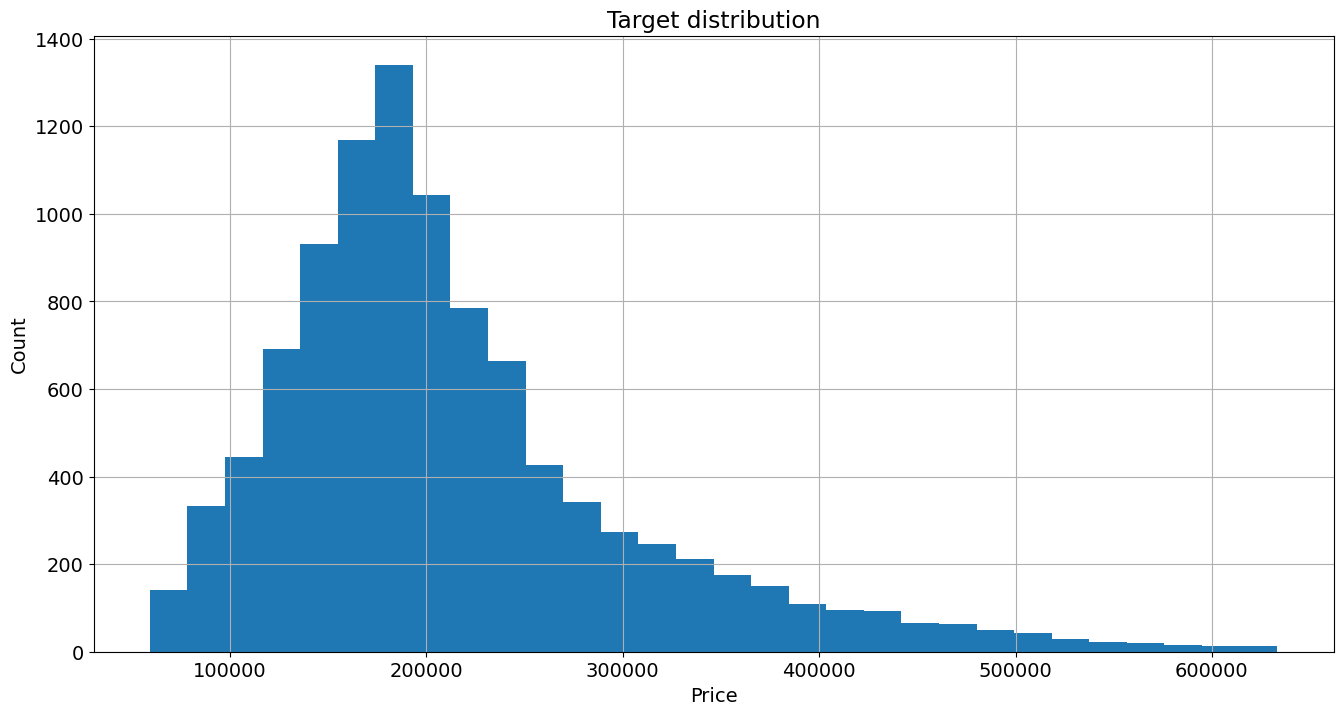

In [71]:
#Целевая переменная:
plt. figure(figsize = (16, 8))

train_df[ 'Price']. hist(bins=30)
plt. ylabel('Count' )
plt. xlabel('Price')

plt. title('Target distribution' )
plt.show

array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Square'}>,
        <Axes: title={'center': 'LifeSquare'}>,
        <Axes: title={'center': 'KitchenSquare'}>],
       [<Axes: title={'center': 'Floor'}>,
        <Axes: title={'center': 'HouseFloor'}>,
        <Axes: title={'center': 'HouseYear'}>,
        <Axes: title={'center': 'Ecology_1'}>],
       [<Axes: title={'center': 'Social_1'}>,
        <Axes: title={'center': 'Social_2'}>,
        <Axes: title={'center': 'Social_3'}>,
        <Axes: title={'center': 'Healthcare_1'}>],
       [<Axes: title={'center': 'Helthcare_2'}>,
        <Axes: title={'center': 'Shops_1'}>,
        <Axes: title={'center': 'Price'}>, <Axes: >]], dtype=object)

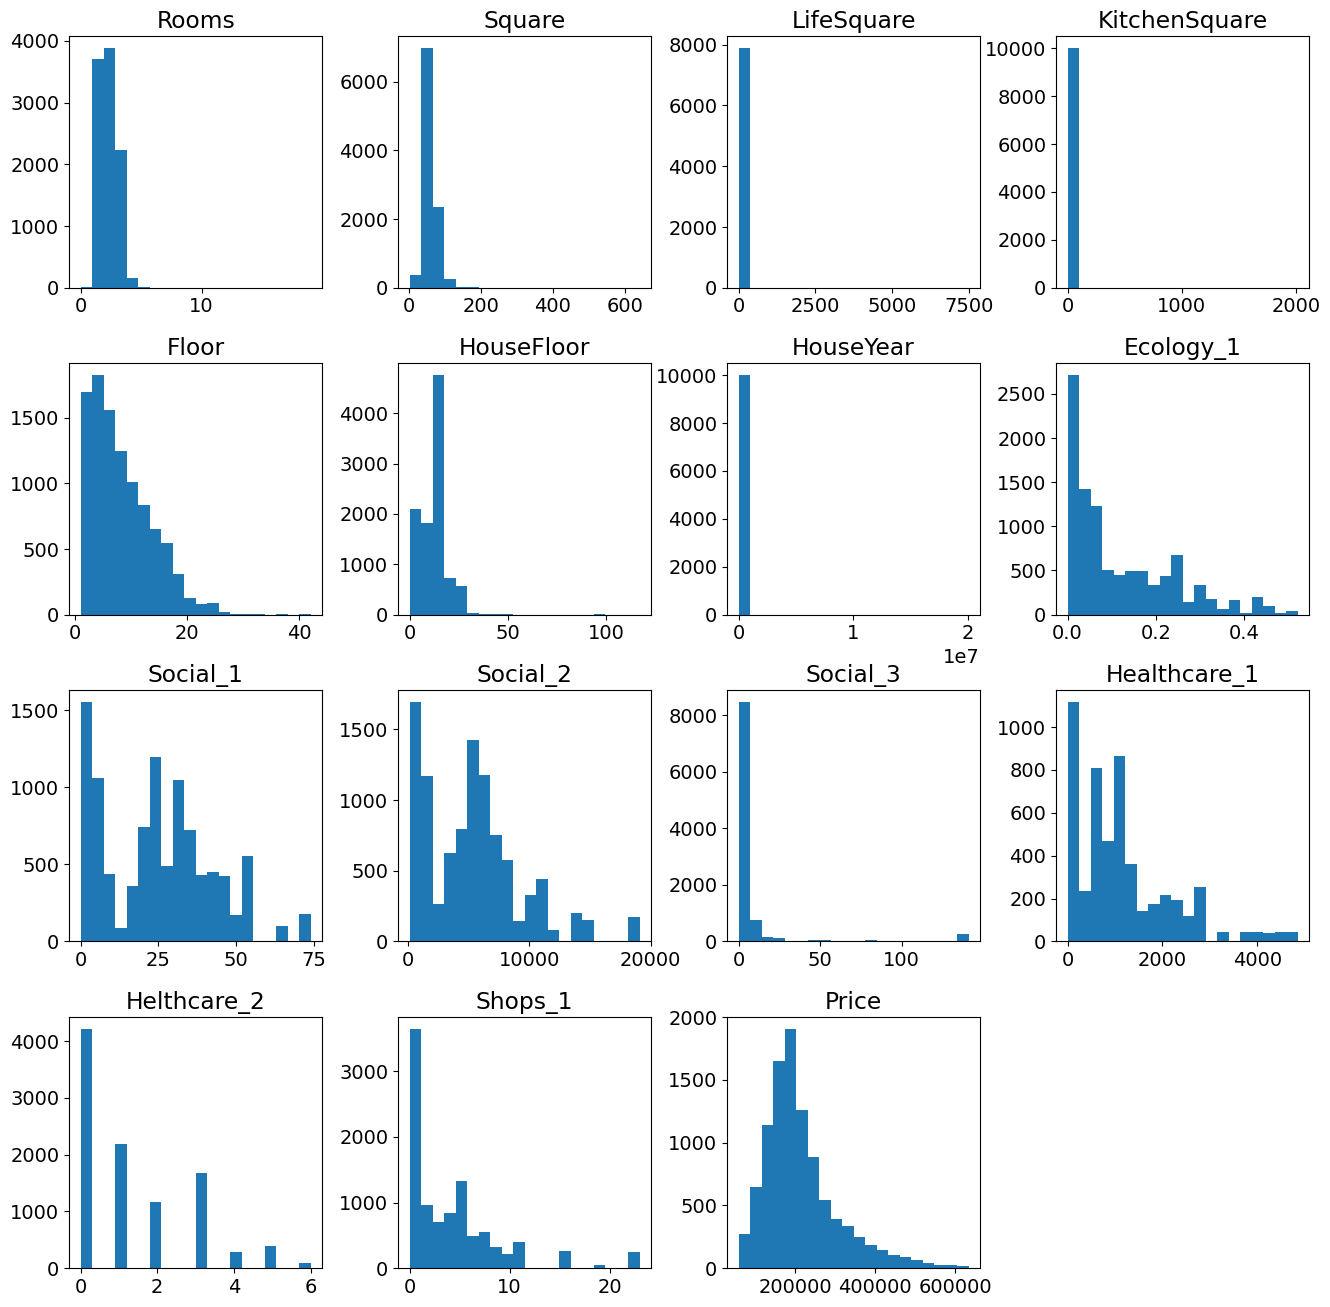

In [72]:
train_df.hist(figsize=(16,16), bins=20, grid=False)

Обработка выбросов:

In [73]:
#Rooms:
train_df['Rooms']. value_counts()

Rooms
2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: count, dtype: int64

 В датасете есть данные, в которых 0 комнат или очень много больше 6ти(возможно, просто ошибка), поэтому создадим новый признак Rooms_outlier,в который будем помещать под 0 - истинные значения, под 1 -значения, возможно, неверные.

In [74]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0)|(train_df['Rooms'] >= 6),'Rooms_outlier'] = 1


In [75]:
train_df['Rooms_outlier'].value_counts()

Rooms_outlier
0    9988
1      12
Name: count, dtype: int64

Заполним медианой всё,что больше 6 и 0 - единичкой.

In [76]:
train_df.loc[train_df[ 'Rooms'] == 0,'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6,'Rooms']= train_df['Rooms'].median()

In [77]:
train_df['Rooms'].value_counts()

Rooms
2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: count, dtype: int64

In [78]:
#KitchenSquare:
train_df['KitchenSquare'].value_counts()

KitchenSquare
1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
32.0         2
41.0         2
51.0         2
30.0         2
112.0        2
37.0         2
43.0         2
25.0         2
58.0         2
84.0         1
75.0         1
21.0         1
54.0         1
62.0         1
40.0         1
29.0         1
1970.0       1
27.0         1
39.0         1
35.0         1
23.0         1
73.0         1
31.0         1
60.0         1
63.0         1
42.0         1
36.0         1
96.0         1
26.0         1
53.0         1
78.0         1
66.0         1
2014.0       1
48.0         1
72.0         1
123.0        1
Name: count, dtype: int64

<Axes: ylabel='KitchenSquare'>

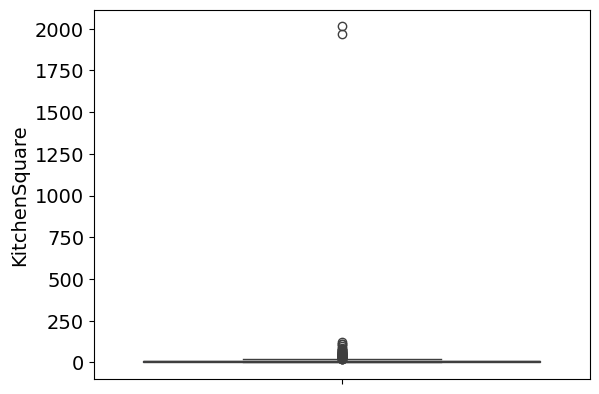

In [79]:
sns.boxplot(train_df.KitchenSquare)

In [80]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

Возможно, неадекватные значения площади кухни.Квантиль позволяет нам указать процентное соотношение наших данных. Он поделит на равные части и возьмёт 975 часть. И мы увидим,что значение близкое к максимуму(100%). В датасете это 13 , а значение близкое к минимуму 0.

In [81]:

train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [82]:
#все заполненные значения признака заменяем :те,что больше 0,975-медианой,
#меньше 3 - тройкой.
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))

train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

Мы видим более адекватные значения:

In [83]:
train_df['KitchenSquare'].value_counts()

KitchenSquare
3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: count, dtype: int64

In [84]:
#HouseFloor, Floor:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [85]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

Явное несоответствие в данных:

In [86]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

Показана разница между этажами , где расположены объекты и общей этажностью. В данном датасете разница 1825 , что является явной аномалией.

In [87]:
train_df['HouseFloor_outlier'] = 0 #создадим фиктивную переменную
train_df.loc[train_df['HouseFloor'] == 0,'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df[ 'HouseFloor'], 'HouseFloor_outlier'] = 1

In [88]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor']= train_df[ 'HouseFloor'].median ()

In [89]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df[ 'HouseFloor' ]].index
floor_outliers

Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
       ...
       9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
      dtype='int64', length=1610)

In [90]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers,"HouseFloor" ]\
                                                 .apply(lambda x: random. randint (1, x))

In [91]:
#В итоге будет 0.
(train_df['Floor']> train_df[ 'HouseFloor' ]).sum()

0

In [92]:
#Объект HouseYear:

train_df['HouseYear'].sort_values(ascending= False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

Есть ошибки в написании года;

In [93]:
train_df.loc[train_df[ 'HouseYear'] > 2024,'HouseYear'] = 2024

In [94]:
train_df['HouseYear'].sort_values(ascending=False)

4189    2024
1497    2024
5701    2020
2493    2020
1499    2020
        ... 
7611    1916
910     1914
2656    1912
5111    1912
9317    1910
Name: HouseYear, Length: 10000, dtype: int64

Обработка пропусков:

In [95]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [96]:
#LifeSquare(есть NAN):

train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df[ 'LifeSquare'].isna())\
            & (~train_df[ 'Square']. isna()) \
            & (~train_df['KitchenSquare'].isna())

In [97]:
train_df.loc[condition,'LifeSquare'] = train_df.loc[condition,'Square']\
                                           - train_df.loc[condition, 'KitchenSquare']

In [98]:
#Healthcare_1:

train_df.drop('Healthcare_1', axis=1, inplace=True)# inplace=True - заменить в исходном датасете.
#посчитали,что этот признак будет не информативен.

In [99]:
train_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
LifeSquare_nan        0
dtype: int64

Создадим класс, чтобы не проводить все те же решения с тестовым датасетом:

In [136]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__ (self):
        """Параметры класса""" #которые мы использовали
        self.medians = None
        self.kitchen_square_quantile = None

    def fit(self, X):  #Х-признак,который хотим обработать
        """Сохранение статистик"""
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)#c квантилями работали только с этим признаком

    def transform(self, X):         #Для тестовых данных применяем только transform
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6),'Rooms_outlier'] = 1
        X.loc[X['Rooms'] == 0,'Rooms' ] = 1
        X.loc[X['Rooms'] >= 6,'Rooms']= self.medians ['Rooms']

        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    |(X['KitchenSquare'] > self.kitchen_square_quantile)

        X.loc[condition, 'KitchenSquare'] = self.medians ['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3

        # HouseFLoor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0,'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians ['HouseFloor']
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers,'Floor'] = X.loc[floor_outliers,'HouseFloor']\
                                          .apply(lambda x: random.randint (1, x))

        # HouseYear
        current_year = datetime.now().year

        X['HouseYear_outLier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outLier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year

        # HeaLthcare_1
        if ('Healthcare_1','Ecology_2','Ecology_3','Shops_2','Id','DistrictId') in X.columns:
            X.drop(['Ecology_2','Ecology_3','Shops_2','Id','DistrictId','Healthcare_1'], axis=1, inplace=True)


        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())

        X.loc[condition,'LifeSquare'] = X.loc[condition,'Square'] - X.loc[condition,'KitchenSquare']

        X.fillna(self.medians, inplace=True)
        return X


In [137]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [138]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
X = train_df.drop(columns='Price')
y = train_df['Price']

In [139]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [140]:
X_train.drop(['Ecology_2','Ecology_3','Shops_2','Id','DistrictId','Healthcare_1'], axis=1, inplace=True)

In [141]:
X_valid.drop(['Ecology_2','Ecology_3','Shops_2','Id','DistrictId','Healthcare_1'], axis=1, inplace=True)

In [142]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)


X_train.shape, X_valid.shape, test_df.shape

((6700, 17), (3300, 17), (5000, 23))

In [143]:
rf_model = RandomForestRegressor(random_state=21,criterion='squared_error')    #criterion= 'mse'
rf_model.fit(X_train, y_train) #знакомим модель с X_train, y_train

RandomForestRegressor(random_state=21)

Train R2:	0.962
Test R2:	0.712


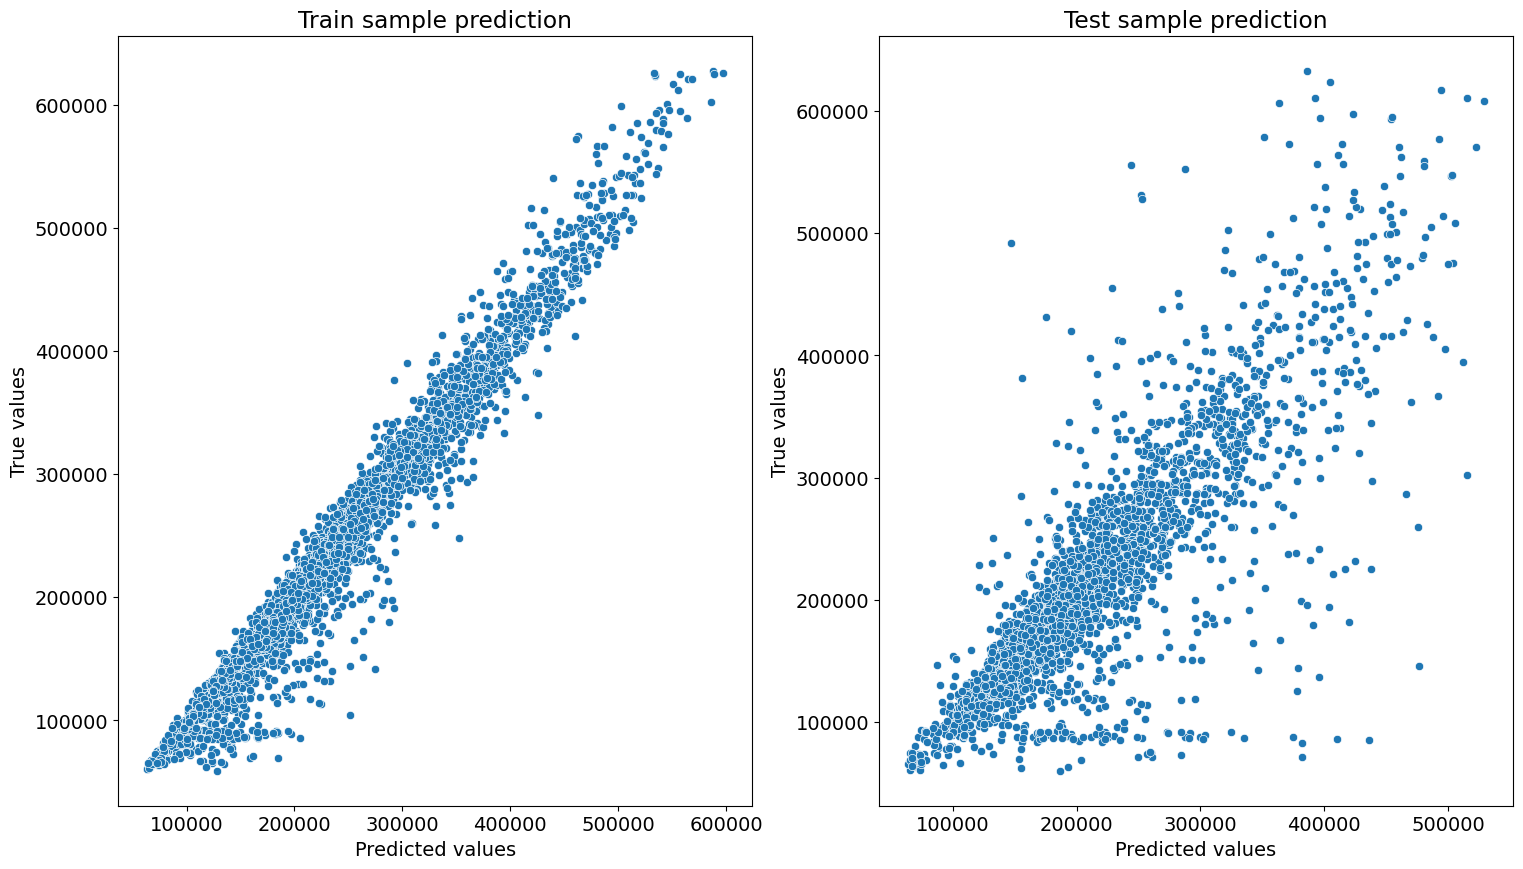

In [147]:
y_train_preds = rf_model.predict (X_train)
y_test_preds = rf_model.predict(X_valid) #здесь играет роль тестовой выборки,чтобы понять как ведёт себя
#модель на новых данных.

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [150]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3,shuffle=True,random_state=21))
cv_score

array([0.71231975, 0.70422923, 0.72334693])

In [151]:
cv_score.mean()

0.7132986343720692

In [152]:
with open('rf_final_model', 'wb') as file:
    pickle.dump(rf_model, file)